David Fleming 2015

University of Washington

#Snapshot Analysis Pipeline

#TODO

-Add flag for plotting binary orbital elements, put them all on a single, multiaxis plot

-Compute inner disk edge radius as function of time

    -would be useful to determine exactly when radius is found

This script searches for and reads in all snapshots in the CWD, analyzes them, and stores/processes vectors of quantities on interest.

In [43]:
#Imports
#Leave commented out if running as .py file instead of ipython notebook
%matplotlib inline

#Imports
import pynbody
from matplotlib.pylab import *
import matplotlib.pylab as plt
import pynbody.plot.sph as sph
import numpy as np
from scipy import interpolate
import matplotlib.lines as mlines
import matplotlib.colors

#Imports from ICgen-Binary directory
import os
sys.path.append('/astro/users/dflemin3/Desktop/ICgen')
sys.path.append('/astro/users/dflemin3/Desktop')
import isaac
import AddBinary
import binaryUtils
import binary

#Typical plot parameters that make for pretty plots
plt.rcParams['figure.figsize'] = (10,6)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams['font.size'] = 20.0

#Setup
User must provide to the variable "cwd" the full directory name of the dir where the data is.  Then, set the flags to get the analysis you want.

In [44]:
#Tell code where data is
cwd = '/astro/users/dflemin3/Desktop/randinitLowEcc'
os.chdir(cwd)

In [45]:
#Flags to control output.  Can be passed as command line arguments if I make this a script in the future
massFlag = True
torqueFlag = True
resFlag = True
comFlag = True

In [46]:
#Initialize variables to be determined later
steps = 0
nSteps = 0
dDelta = 0
m_disk = 0

#Read in .param file.
Read in .param file in the directory if it exists.  Then initialize the relevant data structures.

In [47]:
#Read in .param file and extract info I need

#Find param file if it exists
for file in os.listdir(cwd):
    if file.endswith(".param"):
        filename = file
        break
    else:
        filename = "Invalid"
        
#No file name so give warning before program dies
if filename == "Invalid":
    print "No .param file found!"

else:
    with open(filename) as f:
        lines = f.readlines()

    #Iterate over lines in param file, look for ones of interest
    for line in lines:
        line = str(line).rstrip('\n')

        #Look for file name
        if "achOutName" in line:
            line = line.lstrip('achOutName')
            line = line.lstrip()
            line = line.lstrip('=')
            line = line.lstrip()
            name = line

        #Look for iOutInterval
        if "iOutInterval" in line:
            line = line.lstrip('iOutInterval')
            line = line.lstrip()
            line = line.lstrip('=')
            line = line.lstrip()
            steps = int(line)

        #Look for number of steps
        if "nSteps" in line:
            line = line.lstrip('nSteps')
            line = line.lstrip()
            line = line.lstrip('=')
            line = line.lstrip()
            nSteps = int(line)

        #Look for dDelta
        if "dDelta" in line:
            line = line.lstrip('dDelta')
            line = line.lstrip()
            line = line.lstrip('=')
            line = line.lstrip()
            dDelta = float(line)
        
#close file
f.close()

In [48]:
#Given the variables just read in, compute how many output files I have to read in, then allocate data for the info I want
num = nSteps/steps + 1
bins = 50
m_max = 5
l_max = 5

#Now allocate numpy arrays to hold information I care about so I can plot and things

#Allocate space for orbital elements

orbElems = np.zeros((num,6))
#Int flags to select orbital elements
[e,a,inc,loan,w,nu] = [0,1,2,3,4,5]

#Other variables of interest
circFreq = np.zeros(num)
comBinary = np.zeros((num,3))
comSystem = np.zeros((num,3))
comCut = np.zeros((num,3))
mass = np.zeros((num,2))
netTorque = np.zeros((num,3))
tau = np.zeros((num,bins,3)) #snapshot, radius, 3 components of torque/mass
zTorque = np.zeros(num)
dedt = np.zeros((num,bins))
eVsRadius = np.zeros((num,bins))
ILR = np.zeros((num,m_max,l_max))
OLR = np.zeros((num,m_max,l_max))
CRR = np.zeros((num,l_max))
omega_d = np.zeros((num,bins))
kappa = np.zeros((num,bins))
r = np.zeros((num,bins))
time = np.linspace(0,dDelta/(2.0*np.pi)*nSteps,num)

#Read snapshots
Reads in all tipsy snapshots and from the data calculates the parameters of interest for later analysis.

In [49]:
%%capture
#Read in files, if I can't open a file, tell user why/which one
#Use capture to suppress stderr output
#First, check to see if I have an archive file for this data set.
#Look in the directory where data is!
#Assume if one exists, they all do

archiveName = name + "_archive.npz"

if (not os.path.exists(archiveName)):
    #No archive file in directory, so load data from snaps
    #Read in initial conditions of the form name.std
    
    print "Loading snapshots, storing in {0} archive.".format(name)
    
    try:
        snap = name + ".std"
        s = pynbody.load(snap)
    except RuntimeError:
        print "No initial conditions found!  Was looking for {0}".format(snap)
    else:
        #Get binary stellar parameters
        x1 = s.stars[0]['pos']
        x2 = s.stars[1]['pos']
        v1 = s.stars[0]['vel']
        v2 = s.stars[1]['vel']
        m1 = s.stars[0]['mass']
        m1i = m1
        m2 = s.stars[1]['mass']
        m2i= m2
        mass[0,:] = [m1,m2]

        #Calculate disk mass
        m_disk = np.sum(s.gas['mass'])

        #Orbital Elements Calculations
        orbElems[0,:] = AddBinary.calcOrbitalElements(x1, x2, v1, v2, m1, m2)
        circFreq[0] = AddBinary.calcCircularFrequency(x1,x2,v1,v2,m1,m2)
        
        #Compute inner, outer radii and radius+bins for future torque/mass calculations
        r_in = 1.0*orbElems[0,a]
        r_out = 4.0*orbElems[0,a]
        r[0,:], rBinEdges = binaryUtils.calcDiskRadialBins(s,r_in,r_out,bins)
        eVsRadius[0,:] = binaryUtils.calcEccVsRadius(s,rBinEdges)
        
        #Center of Mass calculations
        cut = 0.4 #0.4 au cutoff as per Tom's suggestion
        comBinary[0] = AddBinary.calcCOM(m1,m2,x1,x2)
        comSystem[0] = binaryUtils.computeCOM(s.stars,s.gas)
        comCut[0] = binaryUtils.computeCOM(s.stars,s.gas,cutoff=cut,starFlag=False)
        
        #Torque calculations
        if torqueFlag:
            netTorque[0,:] = binaryUtils.calcNetTorque(s.stars,s.gas)
            zTorque[0] = netTorque[0,2]

        #Resonance calculations
        if resFlag:
            tau[0,:,:] = binaryUtils.torqueVsRadius(s,rBinEdges)
            dedt[0,:] = binaryUtils.calcDeDt(s.stars,tau[0,:,:]) #Send in all the torque
            ILR[0,:,:],OLR[0,:,:],CRR[0,:],omega_d[0,:],kappa[0,:]=binaryUtils.findCBResonances(s,r[0],r_in,r_out,m_max,l_max,bins)

    #end reading in ICs

    #Start counting other snapshots    
    i = 1

    while i < num:
        t = str(i*steps)
        pad = t.rjust(6, '0')
        snap = name + "." + pad
        try:
            s = pynbody.load(snap)
        except RuntimeError:
            print "No file found!  Was looking for {0}".format(snap)
            break
        else:
            #Get binary stellar parameters
            x1 = s.stars[0]['pos']
            x2 = s.stars[1]['pos']
            v1 = s.stars[0]['vel']
            v2 = s.stars[1]['vel']
            m1 = s.stars[0]['mass']
            m2 = s.stars[1]['mass']
            mass[i,:] = [m1,m2]

            #Orbital Element Calculations
            orbElems[i,:] = AddBinary.calcOrbitalElements(x1, x2, v1, v2, m1, m2)
            circFreq[i] = AddBinary.calcCircularFrequency(x1,x2,v1,v2,m1,m2)
            
            #Center of Mass calculations
            comBinary[i] = AddBinary.calcCOM(m1,m2,x1,x2)
            comSystem[i] = binaryUtils.computeCOM(s.stars,s.gas)
            comCut[i] = binaryUtils.computeCOM(s.stars,s.gas,cutoff=cut,starFlag=False)
            r[i,:], rBinEdges = binaryUtils.calcDiskRadialBins(s,r_in,r_out,bins)
            eVsRadius[i,:] = binaryUtils.calcEccVsRadius(s,rBinEdges)
            
            #Torque calculations
            if torqueFlag:
                netTorque[i,:] = binaryUtils.calcNetTorque(s.stars,s.gas)
                zTorque[i] = netTorque[i,2]

            #Resonance calculations
            if resFlag:
                tau[i,:,:] = binaryUtils.torqueVsRadius(s,rBinEdges)
                dedt[i,:] = binaryUtils.calcDeDt(s.stars,tau[i,:,:]) #send in all the torque
                ILR[i,:,:],OLR[i,:,:],CRR[i,:],omega_d[i,:],kappa[i,:]=binaryUtils.findCBResonances(s,r[i],r_in,r_out,m_max,l_max,bins)
            print ILR
                
            i += 1

    #end loop, save data in respective archives
    np.savez(archiveName,orbElems=orbElems,mass=mass,time=time,
             tau=tau,dedt=dedt,ILR=ILR,OLR=OLR,CRR=CRR,circFreq=circFreq,
             omega_d=omega_d,kappa=kappa,r=r,eVsRadius=eVsRadius,netTorque=netTorque,
            comBinary=comBinary,comSystem=comSystem,comCut=comCut)
    
#If there is an archive, load data from past archive
else:
    print "Loading from {0} archive.".format(name)
    
    archiveName = name + '_archive.npz'

    #Load from archive
    archive = np.load(archiveName)
    orbElems = archive['orbElems']
    circFreq = archive['circFreq']
    eVsRadius = archive['eVsRadius']
    netTorque = archive['netTorque']
    time = archive['time']
    mass = archive['mass']
    tau = archive['tau']
    dedt = archive['dedt']
    IRL = archive['ILR']
    OLR = archive['OLR']
    CRR = archive['CRR']
    omega_d = archive['omega_d']
    kappa = archive['kappa']
    r = archive['r']
    comBinary = archive['comBinary']
    comSystem = archive['comSystem']
    comCut = archive['comCut']

#House Keeping:
Combine some data arrays for easy axis for later plotting functions.

In [50]:
#Combine radius, omega_disk, and kappa_disk arrays for later
resArr = np.zeros((num,4,bins)) #res(onant)Arr(ay)
for i in range(0,num):
    resArr[i] = (r[i],omega_d[i],kappa[i],dedt[i])

#Define indices for easy axis
indexR = 0
indexO = 1
indexK = 2
indexE = 3

semi = orbElems[0,a]

#Define binary period
ob = 2.0*np.pi/AddBinary.aToP(semi,mass[0,0]+mass[0,1])

#Eccentricity Analysis

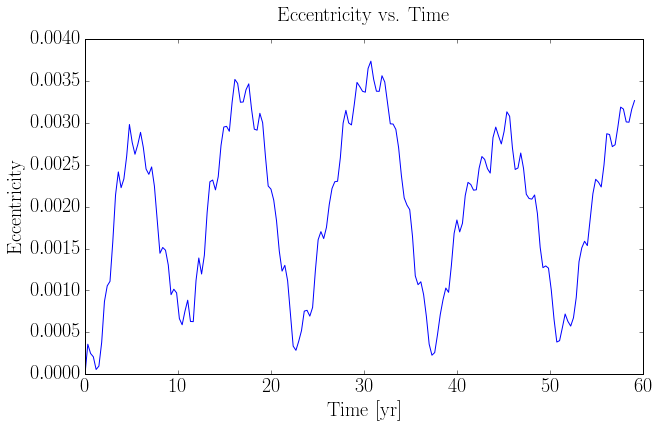

In [51]:
#Produce plot of e vs time
plt.plot(time,orbElems[:,e],label="Simulation")
plt.ylabel("Eccentricity")
plt.xlabel("Time [yr]")
plt.title("Eccentricity vs. Time",y=1.04)

#Semimajor Axis Analysis

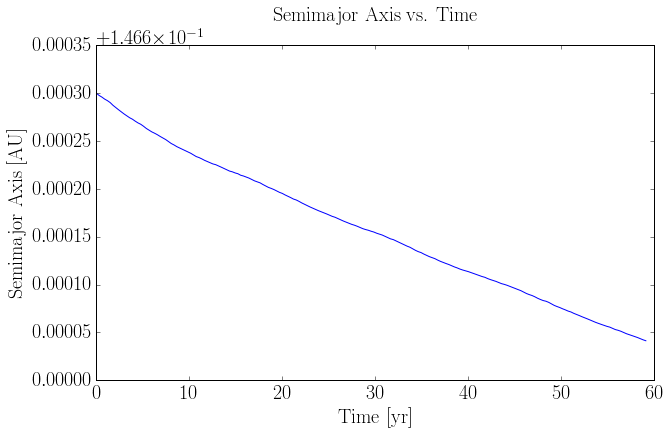

In [52]:
#Produce plot of a vs time
plt.plot(time,orbElems[:,a])
plt.ylabel("Semimajor Axis [AU]")
plt.xlabel("Time [yr]")
plt.title("Semimajor Axis vs. Time",y=1.06)

#Center of Mass
Plot the center of mass location for the binary system and the entire system (binary + system) in order to track how it changes over time.  Ideally, the CoM would remain at the origin (0,0,0) but in practice this doesn't happen.  The below plots help gauge the deviation.

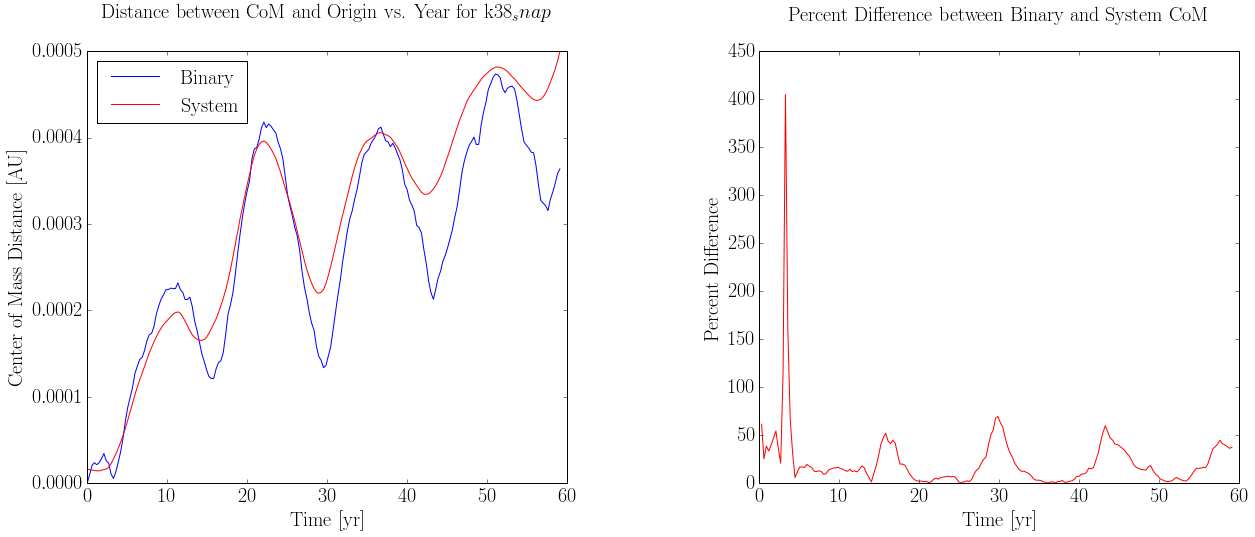

In [53]:
#Produce plot of CoM vs time and other diagnostics
if comFlag:
    #Compute distance between Binary, System CoM and origin
    comBin = np.asarray(comBinary)
    comBin_dist = np.linalg.norm(comBinary,axis=1)
    comSys = np.asarray(comSystem)
    comSys_dist = np.linalg.norm(comSystem,axis=1)
    
    #Compute % diff
    diff = np.fabs(100.0*(comBin_dist - comSys_dist)/comBin_dist)

    #Produce plots
    fig = plt.figure()
    fig.subplots_adjust(left=-0.3, right=1.3,
                        bottom=0.0, top=1.0,
                        hspace=0.0, wspace=0.4)

    #Plot CoM vs time
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(time,comBin_dist,color='blue',label='Binary')
    ax1.plot(time,comSys_dist,color='red',label='System')
    ax1.set_ylabel("Center of Mass Distance [AU]")
    ax1.set_xlabel("Time [yr]")
    ax1.set_title("Distance between CoM and Origin vs. Year for {0}".format(name),y=1.06)
    plt.legend(loc='upper left')
    
    #Plot % diff.  Ignore 1st timestep since it blows up (starts at origin)
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(time[1:],diff[1:],color='red')
    ax2.set_ylabel("Percent Difference")
    ax2.set_xlabel("Time [yr]")
    ax2.set_title("Percent Difference between Binary and System CoM",y=1.06)

else:
    print "Skipping center of mass plots."
    print

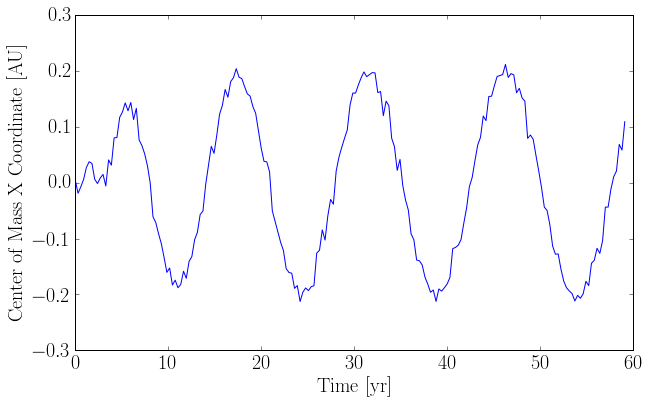

In [54]:
if comFlag:
    plt.plot(time,comCut[:,0])
    plt.xlabel("Time [yr]")
    plt.ylabel("Center of Mass X Coordinate [AU]")
            
else:
    print "Skipping center of mass plots."
    print

#Accretion
Plot the change in stellar mass vs. time and estimate the mean accretion rate $\dot{M}$ in $M_{\odot}/yr$.  For disks with surface densities that go as $r^{-1/2}$, you expect something in around $10^{-8}$ to $10^{-7}$.

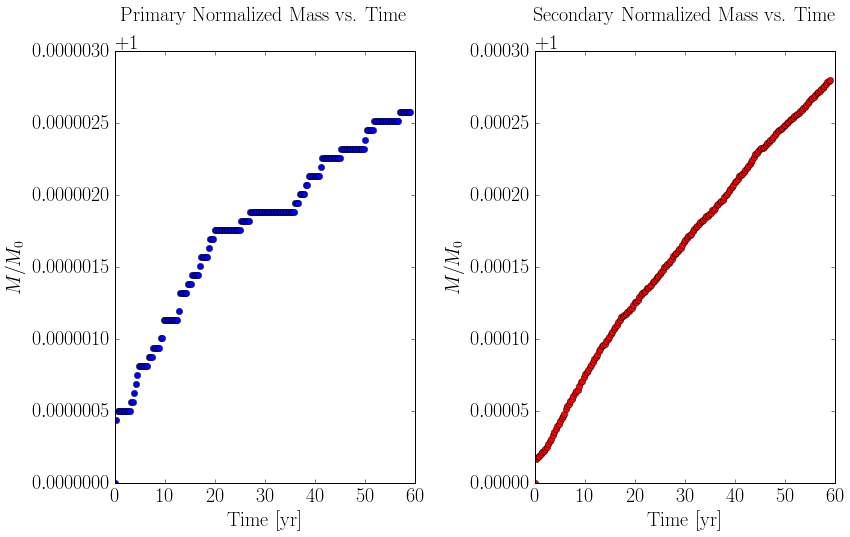

Mean accretion rate = 1.22061549962e-06 solar masses per year.


In [55]:
if massFlag:
    #Create figure, make it look nice
    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1,
                        bottom=0.0, top=1.0,
                        hspace=0.0, wspace=0.4)

    #Primary
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(time,mass[:,0]/mass[0,0],'o',color='blue',label="Primary")
    ax1.set_ylabel(r"$M/M_0$")
    ax1.set_xlabel("Time [yr]")
    ax1.set_title("Primary Normalized Mass vs. Time",y=1.06)

    #Secondary
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(time,mass[:,1]/mass[0,1],'o',color='red',label="Secondary")
    ax2.set_ylabel(r"$M/M_0$")
    ax2.set_xlabel("Time [yr]")
    ax2.set_title("Secondary Normalized Mass vs. Time",y=1.06)

    plt.show()
    
    #Now calculate mean accretion rate
    deltaM = (mass[-1,0] - mass[0,0]) + (mass[-1,1] - mass[0,1])
    mDot = deltaM/(time[-1])
    print "Mean accretion rate =",mDot, "solar masses per year."
    
else:
    print "Skipping Mass plots."
    print

#Torque as a function of radius
Plot the torque per unit mass on binary system due to the CB disk as a function of disk radius.  

First compute the next force on each star due to every single gas particle in the given radial bin.  For torque, $\tau = \vec{r} \times \vec{F}$, take the moment arm to be the distance from the center of mass of the entire system to the given star.  The force vector points from the given star to the collection of gas particles considered. I'll normalize the torque on each star by that star's mass.  Sum up the torque on each star to get the result.

Procedure:
>Calculate the time-averaged net torque on the binary due to the disk at a given radius.  For time-average, simply take mean of torque/mass vs. radius calculations at each radius over range of snapshots.  Note: Must ensure that snapshots are a few binary orbits apart for this to make sense.  The main effects are expected to happen at the apastron when the interaction is strongest due to those parts of the disk rotating more slowly than the binary itself (Artymowics+1991).

Vectors:
>$\vec{r}$ points from the center of mass to the star while the force is due to the gas particles pulling on the star.  Reminder: the radius points from the axis of rotation (center of mass in this case) to the rotating object.  Also, $\vec{F}$ points from the star to the gas.

What I expect:
>I expect to see a negative net torque.  Since the system rotates CCW, a torque < 0 would imply angular momentum is leaving the system and eccentricity increases corresponding to what is observed.

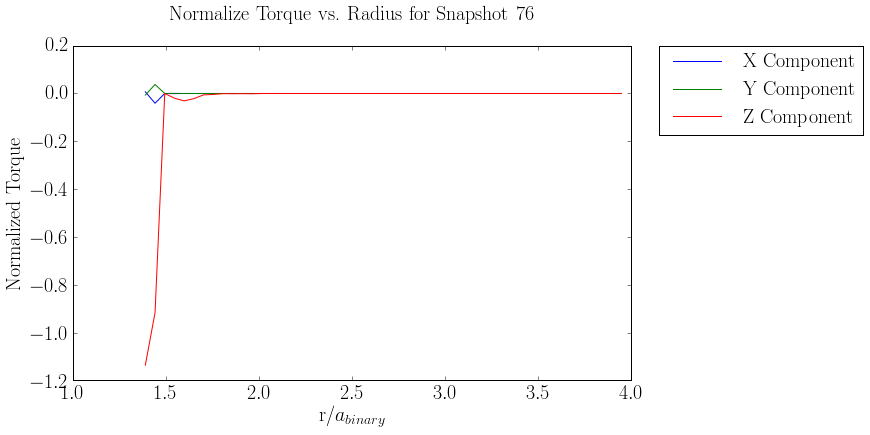

In [56]:
#Plot 3 components of normalize torque for ith snapshot
if torqueFlag:
    i = 76
    
    norm = np.max(tau)
    plt.plot(r[i]/semi,tau[i,:,0]/norm,label="X Component")
    plt.plot(r[i]/semi,tau[i,:,1]/norm,label="Y Component")
    plt.plot(r[i]/semi,tau[i,:,2]/norm,label="Z Component")

    
    #Make plot look nice
    plt.title("Normalize Torque vs. Radius for Snapshot {0}".format(i),y=1.06)
    plt.xlabel("r/$a_{binary}$")
    plt.ylabel("Normalized Torque")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
else:
    print "Skipping torque calculations."

#Torque Notes:

The z component of the torque dominates as expected for a thin, (initially) axisymmetric disk.  The z component torques on the binary causing the system's eccentricity to slowly increase over time.  Since torques can't occur for a perfectly axisymmetric system, some sort of resonance must be at work.  Given the predictions of Artymowicz+1991, we'd expect the Outer Lindblad Resonances (OLR) to provide most of the torque.

#Resonance Calculations

Plot the change in eccentricity over time (de/dt) vs. the disk orbital frequency $\Omega_{disk}$ to see at which location in the disk the majority of the torque comes from.  From these locations, we can see if they correspond to a resonance as theoretically expected.

Theory:

First, we must compute de/dt as a function of radius.  To do this, I took the time derivative of the equation for the eccentricity of a binary system
>$de/dt = d/dt\left( \sqrt{1 + \frac{2 \epsilon h^2}{\mu^2}} \right) =  \left( 1 + \frac{2 \epsilon h^2}{\mu^2} \right)^{-1/2} \left( \frac{2 \epsilon h}{\mu^2} \right) dh/dt $ 
    
where dh/dt is the torque per unit mass at a given disk radius, $\mu = G(m_1+m_2)$  and the specific energy $\epsilon$ is assumed roughly constant since the semimajor axis of the orbit does not change much.  Note, only the z component of dh/dt is used since as shown in the plot above, it dominates.


In order to calculate the location of the resonances in the circumbinary disk, the following formulas are used:
>Lindblad Resonance: $m(\Omega_{disk} - \Omega_{binary}) = \pm l \kappa$

for integer m, l.  $\Omega_{disk}$ is the angular frequency of a annulus of gas in the disk, $\Omega_{binary}$ is the mean angular frequency of the binary system and defines the angular pattern speed of the binary potential that perturbs the disk.  $\kappa$ is the radial epicycle frequency of the same annulus of gas considered earlier.

>Corotation Resonance: $\Omega_{disk} = \Omega_{binary}/l$

for integer l.

Procedure:
>After calculating de/dt, I can plot this as a function of disk radius to see which locations in the disk cause the most torque on the binary.  Next given the resonance formulas, I compute the theoretical locations of the resonances for each snapshot and return the $\Omega$ in the disk where they exist.  I can then plot these against the de/dt curves to verify that de/dt is in fact due to resonances and to see which resonances contribute most strongly.

What I expect:
>In accordance with Artymowics+1991, I expect to see the Outer Lindblad Resonances (OLR) contribute to de/dt and dominate over the Inner (OLR) and Corotation (CRR).  Also since the inner disk is truncated via gap formation and has much less mass then the middle portions of the disk (i.e. where the power law component begins), I expect higher order l modes of the (m,l) OLR to contribute strongly.

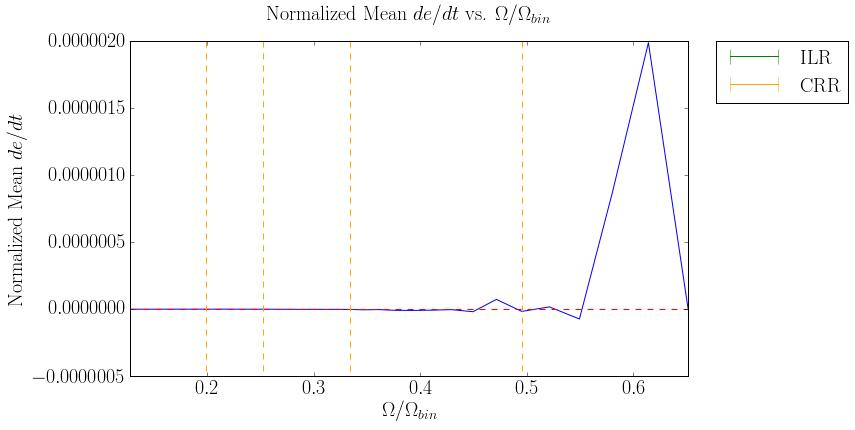

In [57]:
if resFlag:
    i=10
                    
    norm = np.max(dedt)
        
    #Conver x axis from r(au) -> omega normalize by binary omega
    ob = 2.0*np.pi/AddBinary.aToP(semi,mass[0,0]+mass[0,1])
                
    #Plot
    plt.plot(omega_d[i]/ob,dedt[i]/norm)#,drawstyle='steps')
    plt.xlabel("$\Omega / \Omega_{bin}$")
    plt.ylabel(r"Normalized Mean $de/dt$")
    plt.title(r"Normalized Mean $de/dt$ vs. $\Omega / \Omega_{bin}$",y=1.04)
    
    #Plot y = 0 for reference
    plt.axhline(y=0, xmin=-1,xmax=4.1,linewidth=1,color='red',linestyle='--')
    
    #Plot inner lindblad resonance
    for m in range(1,m_max):
        for l in range(0,l_max):
            l = 3
            val = ILR[i,m,l]
            plt.axvline(x=val/ob,ymin=-1,ymax=1,linewidth=1,color='green',linestyle='--')
        
    #Plot corotation resonance
    for l in range(0,l_max):
        plt.axvline(x=CRR[i,l]/ob,ymin=-1,ymax=1,linewidth=1,color='orange',linestyle='--',label="CRR")
        
    #Style plot
    plt.xlim([np.min(omega_d[i])/ob,np.max(omega_d[i])/ob])
    inner = mlines.Line2D([], [], color='green', marker='|',markersize=15, label='ILR')
    crr = mlines.Line2D([], [], color='orange', marker='|', markersize=15, label='CRR')
    
    plt.legend(handles=[inner,crr],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
else:
    print "Skipping de/dt calculation."
    print

Notes:

ILRs don't really contribute at all to any de/dt.  CRRs also seem to not do much except sometimes they do contribute to -dt/dt, but not on the same order of magnitude as OLRs contribute to +de/dt.

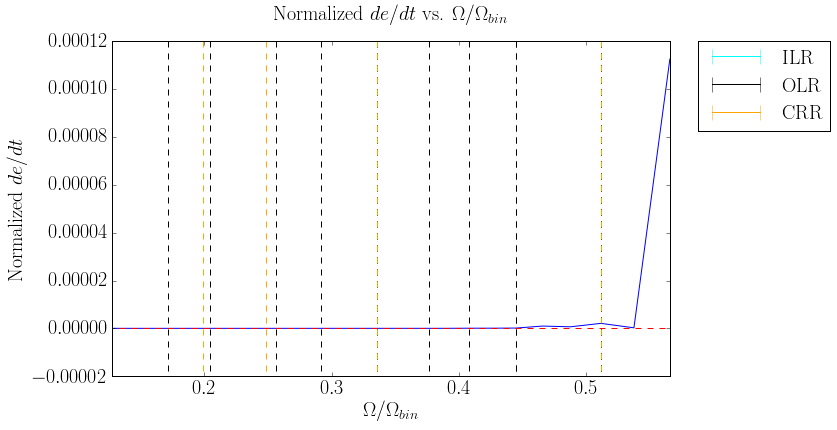

In [58]:
#Plot
if resFlag:
    i = 7

    #Conver radius array to omega and normalize by binary frequency
    ob = 2.0*np.pi/AddBinary.aToP(semi,mass[0,0]+mass[0,1]) #binary frequency

    norm = np.max(dedt)

    #Plot de/dt with arbitrary normalization
    plt.plot(omega_d[i]/ob,dedt[i]/norm)
    plt.xlabel("$\Omega / \Omega_{bin}$")
    plt.ylabel(r"Normalized $de/dt$")
    plt.title(r"Normalized $de/dt$ vs. $\Omega / \Omega_{bin}$",y=1.04)

    #Plot y = 0 for reference
    plt.axhline(y=0, xmin=-1,xmax=4.1,linewidth=1,color='red',linestyle='--')

        #Plot LRs
    for m in range(0,m_max):
        for l in range(0,l_max):
            val = OLR[i,m,l]
            plt.axvline(x=val/ob,ymin=-1,ymax=1,linewidth=1,color='black',linestyle='--')
            val = ILR[i,m,l]
            plt.axvline(x=val/ob,ymin=-1,ymax=1,linewidth=1,color='cyan',linestyle='--')

    #Plot corotation resonance
    for l in range(0,l_max):
        plt.axvline(x=CRR[i,l]/ob,ymin=-1,ymax=1,linewidth=1,color='orange',linestyle='--',label="CRR")
        pass

    #Style plot
    plt.xlim([np.min(omega_d[i])/ob,np.max(omega_d[i])/ob])
    outer = mlines.Line2D([], [], color='black', marker='|',markersize=15, label='OLR')
    inner = mlines.Line2D([], [], color='cyan', marker='|',markersize=15, label='ILR')
    crr = mlines.Line2D([], [], color='orange', marker='|', markersize=15, label='CRR')

    plt.legend(handles=[inner,outer,crr],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

else:
    print "Skipping resonances calculation."

#Plotting Function
Define plotting function to plot LRs given snapshot number, dedt array, $\Omega_{disk}$ array, and $\kappa$ array.

TODO: Alter so it can accept/plot/discriminate between OLR,ILR,CRR or any combination

In [59]:
def plotLR(snap,ob,resArr,OLR,m,l):
    """
    Given the snapshot number and appropriate data arrays, plot the OLR as a function of binary
    disk angular frequency.  Also plot the location in frequency-frequency space where the given
    resonance occurs.  
    Note: -all angular frequencies MUST be in the same units for this to work.
           Should all be precomputed above in 1/day
          -All arrays are numpy arrays unless otherwise specified
    
    Inputs
    snap: snapshot num (integer)
    ob: angular frequency of binary
    dedt: Array of change in e vs time of the shape (number of snaps, radial bins)
          Need the entire array for proper normalization
    resArr: array of the form (r,omega_disk,kappa_disk,dedt)
    OLR: array of outer Lindblad resonances.  Could replace this with ILR if you want.
         array of the form (snapshot number, m, l)
    m,l: arrays of m, l values to plot.  Don't use too many or the plots become unreadable.
    
    Outputs
    2 plots showing correspondence between LRs.  Note, any plotted value of de/dt isn't really
    significant unless it's > ~0.1.
    """
    #Select snapshot
    i = snap
    omega_d = resArr[i,1]
    r = resArr[i,0]
    kappa = resArr[i,2]
    dedt = resArr[:,3]

    #Select resonances
    m_min = m.min()
    m_max = m.max()
    l_min = l.min()
    l_max = l.max()

    #Estimate location of strongest resonance (e.g. max(de/dt)) as a function of omega_disk
    o_max = omega_d[np.argmax(dedt[i])]/ob
    
    #Create Figure
    plt.rcParams['font.size'] = 15
    fig = plt.figure()
    
    #Left Plot

    #Conver radius array to omega and normalize by binary frequency
    norm = np.max(dedt)

    #Plot de/dt with arbitrary normalization
    ax1 = plt.subplot(121)
    ax1.plot(omega_d/ob,dedt[i]/norm)
    ax1.set_xlabel("$\Omega / \Omega_{bin}$")
    ax1.set_ylabel(r"Normalized de/dt")
    ax1.set_title(r"Normalized de/dt vs. $\Omega / \Omega_{bin}$",y=1.06)

    #Plot y = 0 for reference
    ax1.axhline(y=0, xmin=-1,xmax=4.1,linewidth=1,color='red',linestyle='--')

    #Overplot location of maximum de/dt to see if it aligns with a resonance
    ax1.axvline(x=o_max, ymin=-1,ymax=1,linewidth=1,color='red',linestyle='-')
    
    #Plot LRs
    for m in range(m_min,m_max+1):
        for l in range(l_min,l_max+1):
            val = OLR[i,m,l]
            ax1.axvline(x=val/ob,ymin=-1,ymax=1,linewidth=1,color='black',linestyle='--')

    #Style plot
    ax1.set_xlim([np.min(omega_d)/ob,np.max(omega_d)/ob+0.02])
    outer = mlines.Line2D([], [], color='black', marker='|',markersize=15, label='OLR')
    plt.legend(handles=[outer],bbox_to_anchor=(-.15, 1), loc=1, borderaxespad=0.)

    #Right Plot
    ax2 = plt.subplot(122)

    #Plot binary omega reference line
    ax2.axhline(y=ob/ob,xmin=-1,xmax=1,linewidth=1,color='black',linestyle='--',label=r"$\Omega_{bin}$")

    #Attempt to find resonance
    #ax2.axvline(x=0.43,ymin=-1,ymax=1,linewidth=1,color='black',linestyle='-')

    #Plot LR curves
    for m in range(m_min,m_max+1):
        for l in range(l_min,l_max+1):
            ax2.plot(omega_d/ob,(omega_d+((float(l+1)/(m+1))*kappa))/ob,label="({0},{1})".format(m+1,l+1))

    #Overplot location of maximum de/dt to see if it aligns with a resonance
    ax2.axvline(x=o_max, ymin=-1,ymax=1,linewidth=1,color='red',linestyle='--')
    
    #Style plot
    ax2.set_title("(m,l) Order OLR for Snapshot {0}".format(i+1),y=1.06)
    ax2.set_ylim(0,1.3)
    #ax2.set_xlim([np.min(omega_d)/ob,np.max(omega_d)/ob])
    ax2.set_xlabel(r"$\Omega/\Omega_{bin}$")
    ax2.set_ylabel(r"(Resonance Frequency)/$\Omega_{bin}$")
    leg = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)
    
    #Display figure
    fig.tight_layout() 
    
#end function

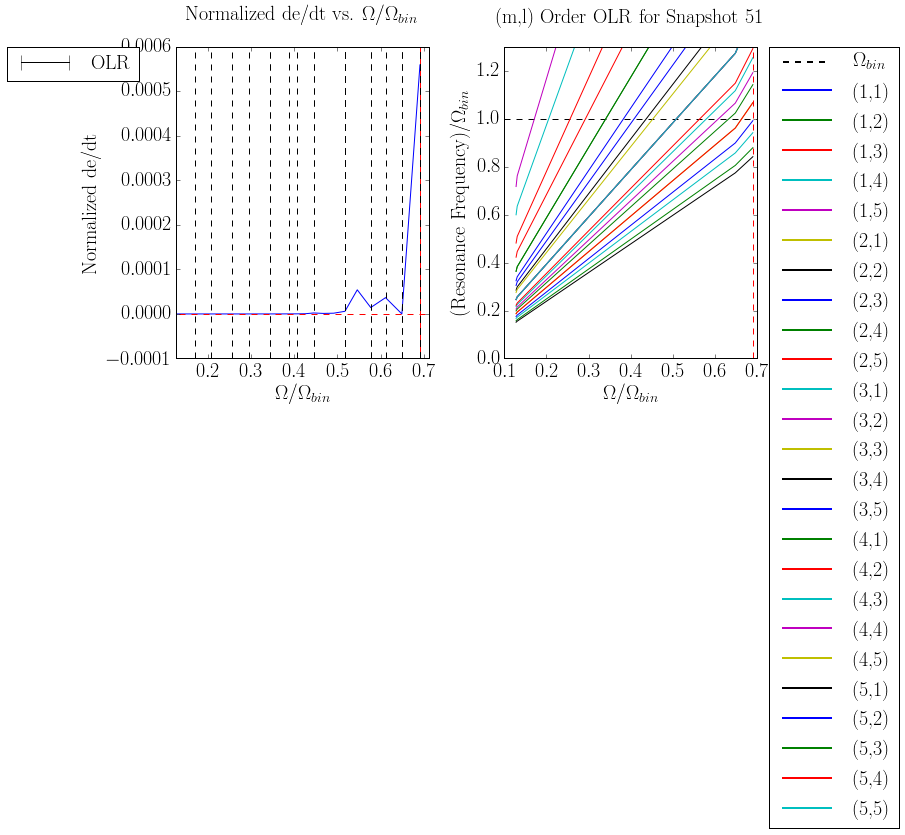

In [60]:
#Try plotting some OLRs
m = np.asarray([0,1,2,3,4])
l = np.asarray([0,1,2,3,4])

plotLR(50,ob,resArr,OLR,m,l)

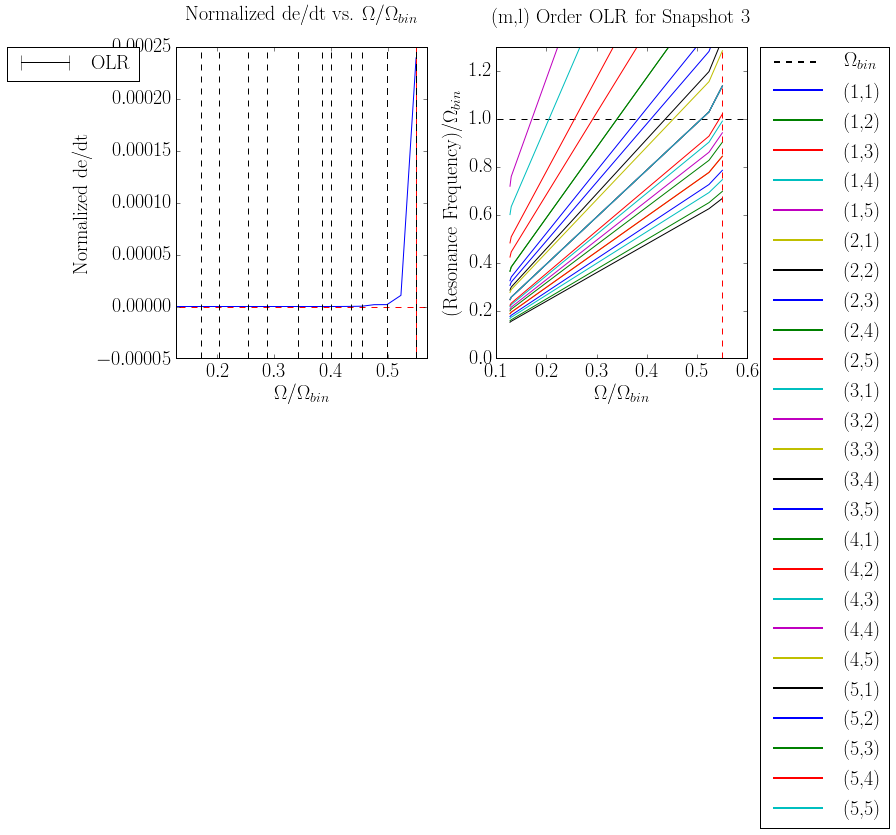

In [61]:
m = np.asarray([0,1,2,3,4])
l = np.asarray([0,1,2,3,4])

plotLR(2,ob,resArr,OLR,m,l)

#de/dt vs True Anomaly ($\nu$).
Since $\nu$ = 0 at the argument of pericenter, would expect the largest torque and hence de/dt to occur at the apocenter, or at $\nu$ = 180 degrees.  This is because at the apocenter ($\nu$ = 180 degrees), the disk has the largest moment arm on the binary and hence the largest torque.  Here, I find that the peak lags 180 degrees implying that perhaps the primary causes a wake in the disk that then tugs on the secondary.

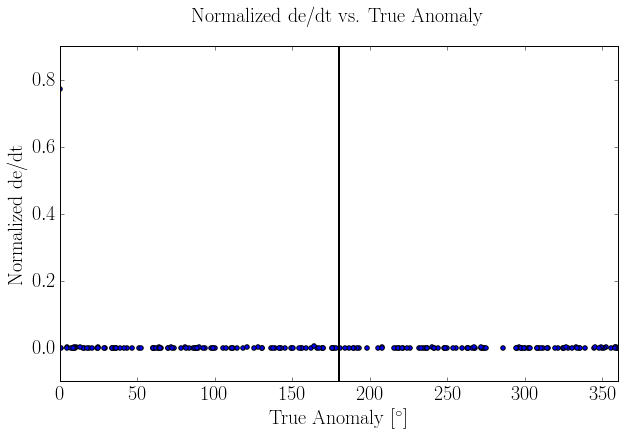

In [62]:
plt.scatter(orbElems[:,nu],np.sum(dedt,axis=1)/np.sum(np.fabs(dedt)))

plt.xlabel("True Anomaly [$^{\circ}$]")
plt.xlim(0,360)
plt.ylabel("Normalized de/dt")
plt.title("Normalized de/dt vs. True Anomaly",y=1.06)
plt.axvline(x=180, ymin=-1, ymax = 1, linewidth=2, color='k') #line at 180 degrees to see if max is there

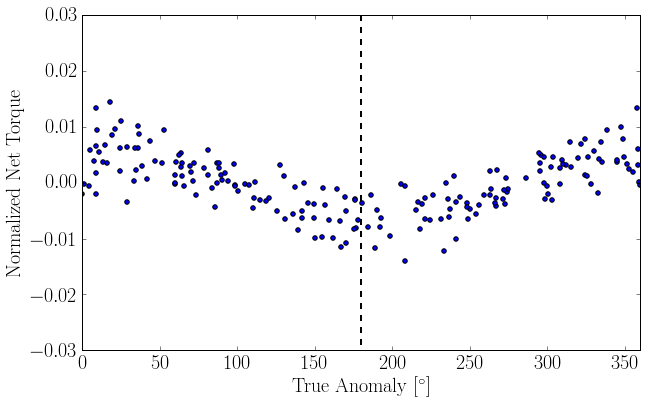

In [63]:
plt.scatter(orbElems[:,nu],np.sum(netTorque,axis=1)/np.sum(np.fabs(netTorque)))

plt.xlabel("True Anomaly [$^{\circ}$]")
plt.xlim(0,360)
plt.ylabel("Normalized Net Torque")
#plt.title("High Ecc",y=1.06)
plt.axvline(x=180, ymin=-1, ymax = 1, linewidth=2, color='k', linestyle='--') #line at 180 degrees to see if max is there

#plt.savefig("bigGap.pdf",bbox_inches='tight')

#Orbital Elements Vs. Time
Plot the orbital elements (except e,a plotted above) vs time and select Poincare elements to examine the evolution of the binary system.

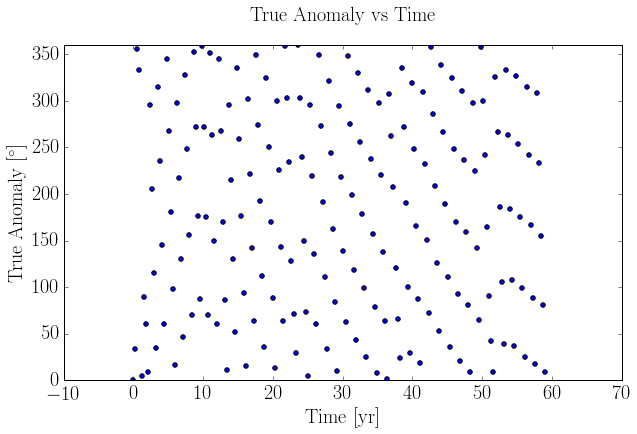

In [64]:
plt.scatter(time,orbElems[:,nu])

plt.xlabel("Time [yr]")
plt.ylim(np.min(orbElems[:,nu]),np.max(orbElems[:,nu]))
plt.ylabel("True Anomaly [$^\circ$]")
plt.title("True Anomaly vs Time",y=1.06)

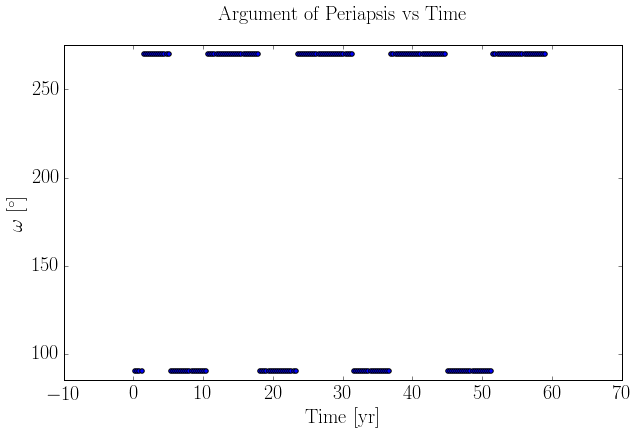

In [65]:
plt.scatter(time[1:],orbElems[1:,w])

plt.xlabel("Time [yr]")
plt.ylim(np.min(orbElems[1:,w]-5),np.max(orbElems[1:,w])+5)
plt.ylabel(r"$\omega$ [$^\circ$]")
plt.title("Argument of Periapsis vs Time",y=1.06)

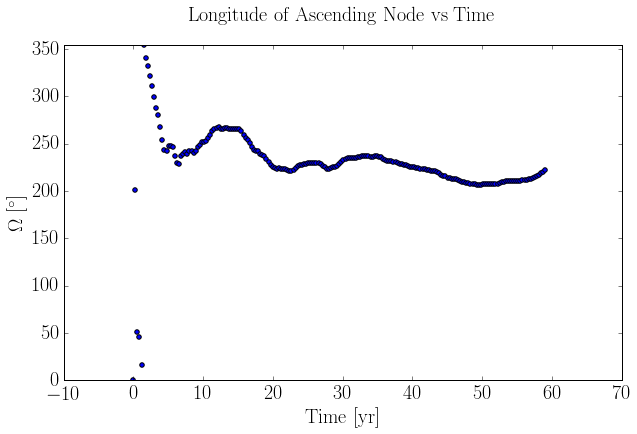

In [66]:
plt.scatter(time,orbElems[:,loan])

plt.xlabel("Time [yr]")
plt.ylim(np.min(orbElems[:,loan]),np.max(orbElems[:,loan]))
plt.ylabel(r"$\Omega$ [$^\circ$]")
plt.title("Longitude of Ascending Node vs Time",y=1.06)

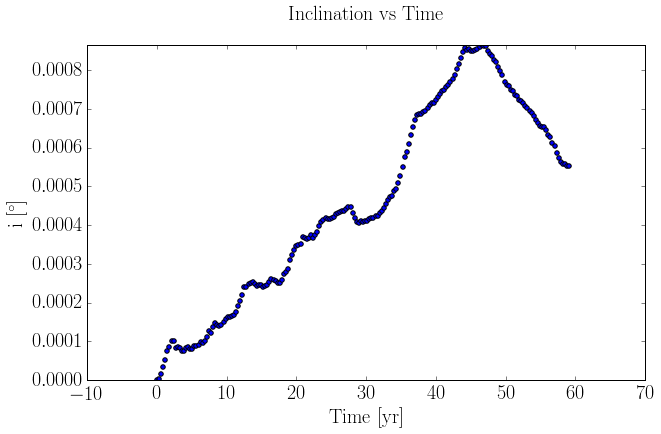

In [67]:
plt.scatter(time,orbElems[:,inc])

plt.xlabel("Time [yr]")
plt.ylim(0,np.max(orbElems[:,inc]))
plt.ylabel(r"i [$^\circ$]")
plt.title("Inclination vs Time",y=1.06)

0.334991012034


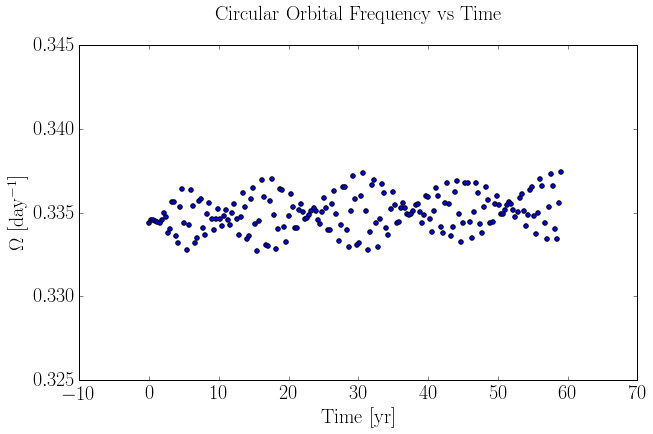

In [68]:
plt.scatter(time,circFreq)

plt.xlabel("Time [yr]")
plt.ylabel(r"$\Omega$ [day$^{-1}]$")
plt.title("Circular Orbital Frequency vs Time",y=1.06)

print np.mean(circFreq)

#Plot Some Poincare Elements
Note: Ignore the first timestep as w=0 throws the range of everything off.

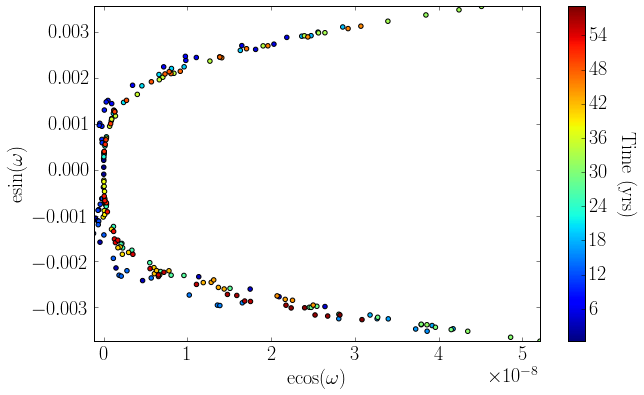

In [69]:
#Plot ecosw, esinw Poincare Elements (convert from degrees to radians!)
conv = np.pi/180.0
scat = plt.scatter(orbElems[1:,e]*np.cos(conv*orbElems[1:,w]),orbElems[1:,e]*np.sin(conv*orbElems[1:,w]),c=time[1:],cmap='jet')
cbar = plt.colorbar(scat)
cbar.set_label("Time (yrs)", labelpad=30, rotation=270)

#Make plot look nice
plt.xlim(min(orbElems[1:,e]*np.cos(conv*orbElems[1:,w])),max(orbElems[1:,e]*np.cos(conv*orbElems[1:,w])))
plt.ylim(min(orbElems[1:,e]*np.sin(conv*orbElems[1:,w])),max(orbElems[1:,e]*np.sin(conv*orbElems[1:,w])))
#plt.title(r"Poincare Elements: ecos($\omega$) vs esin($\omega$)",y=1.06)
plt.xlabel(r"ecos($\omega$)")
plt.ylabel(r"esin($\omega$)")

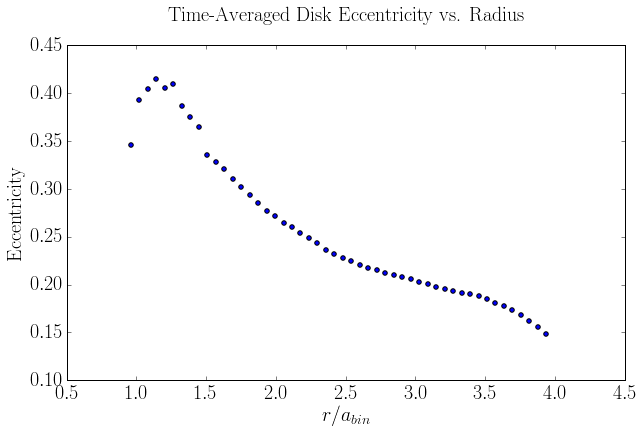

In [70]:
#Plot time averaged eccentricity as a function of disk radius
plt.scatter(r[0,:]/orbElems[0,a],np.sum(eVsRadius,axis=0)/len(eVsRadius))

plt.title("Time-Averaged Disk Eccentricity vs. Radius",y=1.06)
plt.xlabel("$r/a_{bin}$")
plt.ylabel("Eccentricity")

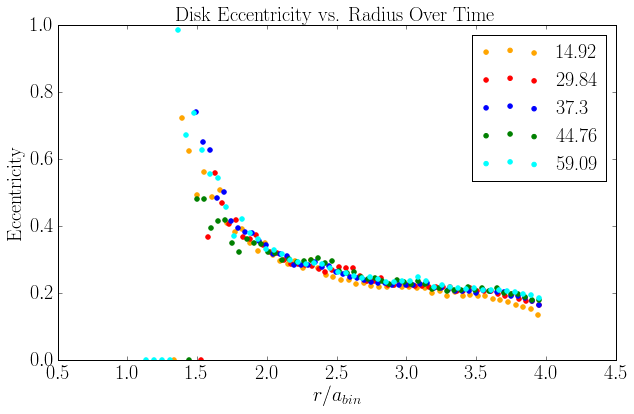

In [71]:
vals = [50,100,125,150,198]
labels = [round(time[val],2) for val in vals]

plt.scatter(r[vals[0],:]/orbElems[vals[0],a],eVsRadius[vals[0],:],color='orange',label=labels[0])
plt.scatter(r[vals[1],:]/orbElems[vals[1],a],eVsRadius[vals[1],:],color='red',label=labels[1])
plt.scatter(r[vals[2],:]/orbElems[vals[2],a],eVsRadius[vals[2],:],color='blue',label=labels[2])
plt.scatter(r[vals[3],:]/orbElems[vals[3],a],eVsRadius[vals[3],:],color='green',label=labels[3])
plt.scatter(r[vals[4],:]/orbElems[vals[4],a],eVsRadius[vals[4],:],color='cyan',label=labels[4])

plt.title("Disk Eccentricity vs. Radius Over Time")
plt.xlabel("$r/a_{bin}$")
plt.ylabel("Eccentricity")
plt.ylim(0,1)
plt.legend()

In [72]:
dt = AddBinary.YEARSEC*(time[1]-time[0])
print np.sum(dedt)*dt

2.00417503269


In [73]:
de = orbElems[-1,e] - orbElems[0,e]
print de

0.00326897208352


In [74]:
fitVals = np.polyfit(time,orbElems[:,e],1) #returns highest value first
print fitVals[0]*(time[-1])

0.000459490302324


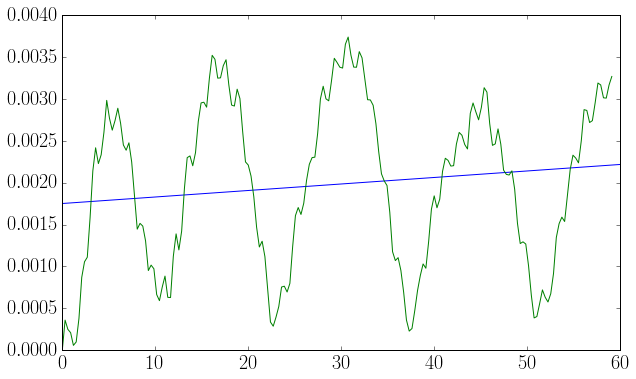

In [75]:
tmpX = np.linspace(0,60,100)
tmpY = fitVals[1] + tmpX*fitVals[0]

plt.plot(tmpX,tmpY)
plt.plot(time,orbElems[:,e])

#Estimate m=1 mode stability

In [76]:
s = pynbody.load("k38_snap.std")
Mdisk = np.sum(s.gas['mass'])
rd = 4.0
print Mdisk
print rd

0.0038305046246
4.0


Loading using backend <class 'pynbody.tipsy.TipsySnap'>
TipsySnap: loading  k38_snap.std
TipsySnap: loading data from main file


In [77]:
r_in = 1.0*orbElems[0,a]
r_out = rd
Qbins = 50
Q, rad =isaac.Q(s,2.35, bins=Qbins)
rad = (rad[1:] + rad[:-1])/2.0

Profile: omega()
Profile: v_circ() -- warning, disk must be in the x-y plane
Rotation curve calculated in 0.105 s


SimSnap: deriving array rxy
SimSnap: deriving array rxy


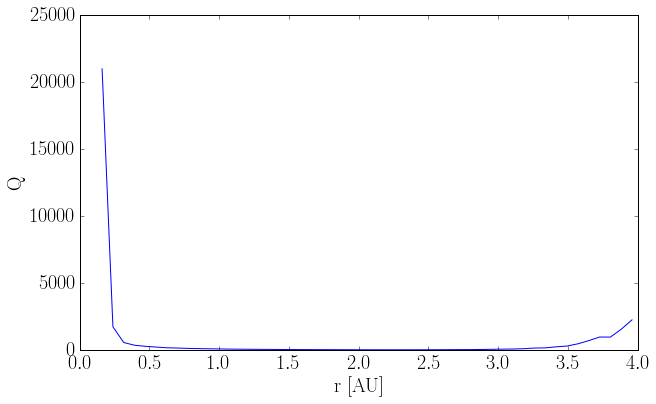

In [78]:
plt.plot(rad,Q)
plt.ylabel("Q")
plt.xlabel("r [AU]")

#plt.savefig("qVsRadius.pdf")

In [79]:
sigma0 = binaryUtils.calcStableSigma(rad,rd,mass[0,0]+mass[0,1],Mdisk,Q[-1])

In [80]:
p = pynbody.analysis.profile.Profile(s.gas,max=r_out,min=r_in,nbins=bins)
sigma = p['density']
sigR = p['rbins']

Profile: density()
Profile: mass()


[]

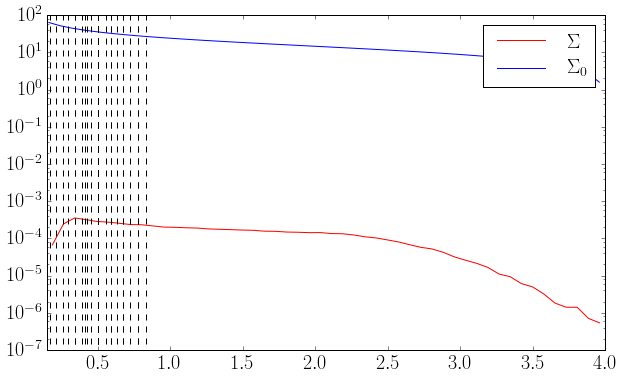

In [81]:
plt.plot(sigR,sigma,color='red',label=r'$\Sigma$')
plt.plot(rad,sigma0,color='blue',label=r"$\Sigma_{0}$")

#Select resonances
m_min = 0
l_min = 0
m_max = 4
l_max = 4
for m in range(m_min,m_max+1):
        for l in range(l_min,l_max+1):
            #m = 0 #0 corresponds to m = 1
            #l = 1
            val = OLR[-1,m,l]
            plt.axvline(x=val/ob,ymin=-1,ymax=1,linewidth=1,color='black',linestyle='--')

plt.xlim(0.15,4)
#plt.ylim(0,0.001)
plt.legend(loc='upper right')
plt.semilogy()

#plt.savefig("shuM0Instability.pdf")